## ML Pipeline Notebook 


### 📘 Project Introduction
This notebook demonstrates the **end-to-end construction of a Machine Learning pipeline** using the **Pediatric Bone Marrow Transplantation dataset** from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/). The dataset contains detailed medical information about pediatric patients who underwent bone marrow transplantation — including donor and recipient characteristics, risk groups, immunological markers, and clinical outcomes.


The primary goal of this project is to **predict patient survival status** after transplantation based on these clinical and demographic features. The task is framed as a **binary classification problem**:
- `0` → Patient survived
- `1` → Patient did not survive


Beyond building a predictive model, the purpose of this project is to showcase the **complete ML workflow**.


### 📊 Dataset Overview
The dataset (`bone-marrow.arff`) contains **187 samples** with **36 features**, covering:
- **Recipient information**: age, gender, blood type, body mass, relapse status, etc.
- **Donor information**: age, blood group, cytomegalovirus (CMV) status, HLA match, etc.
- **Transplantation details**: stem cell source, risk group, relapse indicators, GVHD (Graft versus Host Disease) indicators, etc.
- **Outcome variables**: `survival_time` (continuous), `survival_status` (binary target).


Many features are categorical but encoded as numbers; some are medical risk indicators. The dataset includes missing values and requires careful preprocessing.


### 🎯 Project Goals
- **Reproduce a rigorous ML workflow** on a biomedical dataset.
- **Clean, preprocess, and explore the data** to understand patterns and relationships.
- **Engineer features** (normalization, encoding, discretization, variance filtering).
- **Select and compare classification models** (e.g., Logistic Regression, Random Forest).
- **Evaluate models** using accuracy, precision, recall, F1-score, ROC-AUC.
- **Optimize hyperparameters** via GridSearchCV.
- **Validate the final model** on a hold-out test set.
- **Build and save a robust ML pipeline** for deployment and reproducibility.


### ⚙️ Usage
1. Place the file `bone-marrow.arff` in the working directory (or update the path in the script).
2. Run the notebook cell-by-cell in Jupyter or execute as a Python script .
3. The final trained pipeline will be saved as `final_ml_pipeline.joblib` for later use.



### 1. Imports & Settings
#### Import core libraries for data manipulation, visualization, and ML workflow

In [159]:
import os
import warnings
warnings.filterwarnings('ignore') # to suppress warnings for cleaner output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ARFF format loader for UCI datasets
from scipy.io import arff

# ML utilities from scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import (confusion_matrix, classification_report,
accuracy_score, precision_score, recall_score, f1_score,
roc_auc_score, roc_curve)

# Saving models
import joblib

In [160]:
# Reproducibility
RANDOM_STATE = 42
DATA_PATH = 'bone-marrow.arff'

### 2. ETL (Extract, Transform, Load)
- Load the ARFF file (UCI format) and convert it to a pandas DataFrame
- Keep a copy of the original (text/byte) representation for manual inspection

In [161]:
print('Loading dataset...')
raw = arff.loadarff(DATA_PATH)
# df_raw contains the original values (bytes/strings as provided by UCI)
df_raw = pd.DataFrame(raw[0])
df_raw.drop(columns=['Disease'], inplace=True)
# make a working numeric copy (we will coerce to numeric below and keep df_raw for inspection)
df = df_raw.copy()

Loading dataset...


In [162]:
print('\nDataset preview:')
df.head()


Dataset preview:


,Recipientgender,Stemcellsource,Donorage,Donorage35,IIIV,Gendermatch,DonorABO,RecipientABO,RecipientRh,ABOmatch,...,extcGvHD,CD34kgx10d6,CD3dCD34,CD3dkgx10d8,Rbodymass,ANCrecovery,PLTrecovery,time_to_aGvHD_III_IV,survival_time,survival_status
0,b'1',b'1',22.830137,b'0',b'1',b'0',b'1',b'1',b'1',b'0',...,b'1',7.20,1.338760,5.38,35.0,19.0,51.0,32.0,999.0,0.0
1,b'1',b'0',23.342466,b'0',b'1',b'0',b'-1',b'-1',b'1',b'0',...,b'1',4.50,11.078295,0.41,20.6,16.0,37.0,1000000.0,163.0,1.0
2,b'1',b'0',26.394521,b'0',b'1',b'0',b'-1',b'-1',b'1',b'0',...,b'1',7.94,19.013230,0.42,23.4,23.0,20.0,1000000.0,435.0,1.0
3,b'0',b'0',39.684932,b'1',b'1',b'0',b'1',b'2',b'1',b'1',...,b'?',4.25,29.481647,0.14,50.0,23.0,29.0,19.0,53.0,1.0
4,b'0',b'1',33.358904,b'0',b'0',b'0',b'1',b'2',b'0',b'1',...,b'1',51.85,3.972255,13.05,9.0,14.0,14.0,1000000.0,2043.0,0.0


In [163]:
print('\nDataset info:')
print(df.info())


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Recipientgender       187 non-null    object 
 1   Stemcellsource        187 non-null    object 
 2   Donorage              187 non-null    float64
 3   Donorage35            187 non-null    object 
 4   IIIV                  187 non-null    object 
 5   Gendermatch           187 non-null    object 
 6   DonorABO              187 non-null    object 
 7   RecipientABO          187 non-null    object 
 8   RecipientRh           187 non-null    object 
 9   ABOmatch              187 non-null    object 
 10  CMVstatus             187 non-null    object 
 11  DonorCMV              187 non-null    object 
 12  RecipientCMV          187 non-null    object 
 13  Riskgroup             187 non-null    object 
 14  Txpostrelapse         187 non-null    object 
 15  Diseaseg

#### 2.1 Features of interest 
The dataset columns include many clinical and demographic features. Below are some
input (features) and output (target) variables that are commonly of interest for
this transplant-survival prediction task.

In [164]:
feature_descriptions = {
'donor_age': 'Age of the donor at hematopoietic stem cells apheresis (years)',
'donor_age_below_35': 'Binary indicator: donor age < 35 (1=yes, 0=no)',
'donor_ABO': 'Donor ABO blood group (encoded numerically in the dataset; needs mapping to O/A/B/AB)',
'donor_CMV': 'Presence of cytomegalovirus infection in donor prior to transplant (present/absent)',
'recipient_age': 'Age of the recipient at transplantation (years)',
'recipient_age_below_10': 'Binary indicator: recipient age < 10 (1=yes, 0=no)',
'recipient_age_int': 'Recipient age discretized into intervals (e.g., (0,5], (5,10], (10,20])',
'recipient_gender': 'Recipient gender (female/male)',
'recipient_body_mass': 'Recipient body mass at transplantation (kg)',
'survival_status': 'Outcome target: 0 = alive (survived), 1 = dead (did not survive)'
}

In [165]:
print('\nFeatures of primary interest (examples):')
for k, v in feature_descriptions.items():
    print(f"- {k}: {v}")


Features of primary interest (examples):
- donor_age: Age of the donor at hematopoietic stem cells apheresis (years)
- donor_age_below_35: Binary indicator: donor age < 35 (1=yes, 0=no)
- donor_ABO: Donor ABO blood group (encoded numerically in the dataset; needs mapping to O/A/B/AB)
- donor_CMV: Presence of cytomegalovirus infection in donor prior to transplant (present/absent)
- recipient_age: Age of the recipient at transplantation (years)
- recipient_age_below_10: Binary indicator: recipient age < 10 (1=yes, 0=no)
- recipient_age_int: Recipient age discretized into intervals (e.g., (0,5], (5,10], (10,20])
- recipient_gender: Recipient gender (female/male)
- recipient_body_mass: Recipient body mass at transplantation (kg)
- survival_status: Outcome target: 0 = alive (survived), 1 = dead (did not survive)


Important note (explanation):
The dataset commonly encodes categorical and binary features as numeric codes.
*Examples:*
- Binary columns like donor_age_below_35 are encoded as 0/1 numeric — these are categorical
- Multiclass categorical columns such as donor_ABO may be encoded using integers like -1, 0, 1, 2

we cannot just look for columns of numeric types or object types to define these lists.

In [166]:
#Convert all columns to numeric, coerce errors to null values
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors='coerce')
    
#Make sure binary columns are encoded as 0 and 1
for c in df.columns[df.nunique()==2]:
    df[c] = (df[c]==1)*1.0


In [167]:
# Calculate the number of unique values for each column
print('Count of unique values in each column:')
print(df.nunique())

Count of unique values in each column:
Recipientgender           2
Stemcellsource            2
Donorage                187
Donorage35                2
IIIV                      2
Gendermatch               2
DonorABO                  4
RecipientABO              4
RecipientRh               2
ABOmatch                  2
CMVstatus                 4
DonorCMV                  2
RecipientCMV              2
Riskgroup                 2
Txpostrelapse             2
Diseasegroup              2
HLAmatch                  4
HLAmismatch               2
Antigen                   4
Alel                      5
HLAgrI                    7
Recipientage            125
Recipientage10            2
Recipientageint           3
Relapse                   2
aGvHDIIIIV                2
extcGvHD                  2
CD34kgx10d6             183
CD3dCD34                182
CD3dkgx10d8             163
Rbodymass               130
ANCrecovery              18
PLTrecovery              50
time_to_aGvHD_III_IV     28
survival_

After exploring the unique value counts in each column, we will use 7 as a threshold:

- For columns with more than 7 unique values, we will consider this a numeric variable
- For columns with 7 or less unique values, we will consider this a categorical variable.

In [168]:
# 2. Set target, survival_status,as y; features (dropping survival status and time) as X
y = df.survival_status
X = df.drop(columns=["survival_status","survival_time"])

In [169]:
# 3. Define lists of numeric and categorical columns based on number of unique values
num_cols = X.columns[X.nunique()>7]
cat_cols = X.columns[X.nunique()<=7]

In [170]:
print(X.columns[X.isnull().sum()>0])

Index(['RecipientABO', 'CMVstatus', 'Antigen', 'Alel', 'CD3dCD34',
       'CD3dkgx10d8', 'Rbodymass'],
      dtype='object')


In [171]:
df = df.dropna()

### 3. Train-Test-Validation Split
- Prepare X, y and split while preserving class balance (stratify)

In [172]:
# Basic check - class balance
print('\nTarget class distribution (counts):')
print(y.value_counts())


Target class distribution (counts):
survival_status
0.0    102
1.0     85
Name: count, dtype: int64


In [173]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=RANDOM_STATE)
print('\nData split shapes: Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)


Data split shapes: Train: (130, 34) Val: (28, 34) Test: (29, 34)


### 4. EDA 
- Use our categorical_candidates and numeric_candidates to explore distributions

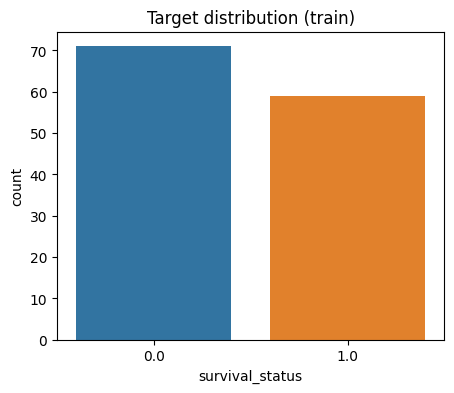

In [174]:
# Visualize target distribution
plt.figure(figsize=(5,4))
sns.countplot(x=y_train)
plt.title('Target distribution (train)')
plt.show()

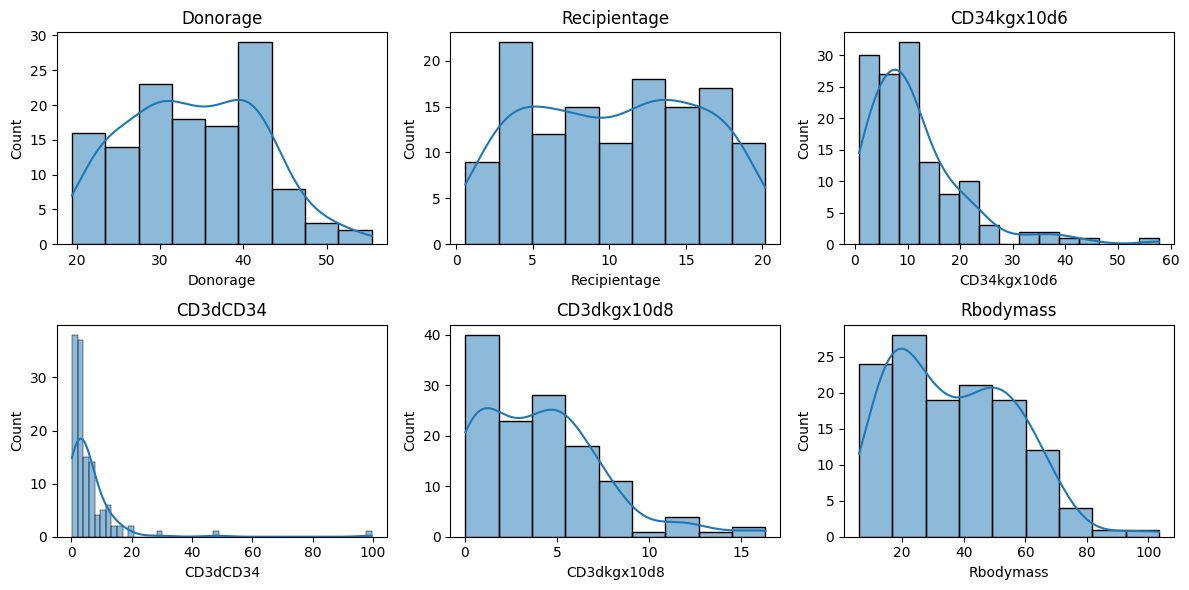

In [175]:
# Show histogram for a few numeric columns
plt.figure(figsize=(12,6))
for i, c in enumerate(num_cols[:6]):
    plt.subplot(2,3,i+1)
    sns.histplot(X_train[c].dropna(), kde=True)
    plt.title(c)
plt.tight_layout()
plt.show()

### 5. Feature Engineering & Preprocessing
- Numerical pipeline: mean imputation -> remove zero-variance -> scaling (StandardScaler)
- Categorical pipeline: most frequent imputation -> OneHotEncoder (handle_unknown='ignore')

#### Create Preprocessing Pipeline

In [176]:
# Create categorical preprocessing pipeline
# Using mode to fill in missing values and OHE
categorical_transformer = Pipeline([
    ("imputer",SimpleImputer(strategy='most_frequent')),
    ("ohe",OneHotEncoder(sparse_output=False, drop='first', handle_unknown = 'ignore'))])

In [177]:

# Create numerical preprocessing pipeline
# Using mean to fill in missing values and standard scaling of features
numeric_transformer = Pipeline([
    ("imputer",SimpleImputer(strategy='mean')), 
    ("scale",StandardScaler())])

In [178]:
# Create column transformer that will preprocess the numerical and categorical features separately
#Apply the pipeline on each part of columns 
preprocess = ColumnTransformer(
    transformers=[
        ("cat_process", categorical_transformer, cat_cols),
        ("num_process", numeric_transformer, num_cols)
    ]
)

### 6. Model Selection & Pipelines
- We'll build two pipeline candidates and compare them using cross-validation

#### Create Classification Pipeline and Tune

In [179]:
#EDA + Feature Engineering + Model selection 
pipe_lr = Pipeline([("preprocess",preprocess), 
                     ("pca", PCA()),
                     ("clf",LogisticRegression(random_state=RANDOM_STATE))])

In [180]:
pipe_rf = Pipeline([
                      ('preprocess', preprocess),
                      ('clf', RandomForestClassifier(random_state=RANDOM_STATE))
])

In [181]:
print('\nCross-validating baseline pipelines (5-fold CV)')
for name, p in [('LogisticRegression', pipe_lr), ('RandomForest', pipe_rf)]:
    scores = cross_val_score(p, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    print(f"{name} mean accuracy: {scores.mean():.3f} (std {scores.std():.3f})")


Cross-validating baseline pipelines (5-fold CV)


/Users/ibtissama/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/ibtissama/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/ibtissama/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/ibtissama/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/ibtissama/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWar

LogisticRegression mean accuracy: 0.738 (std 0.045)


/Users/ibtissama/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


RandomForest mean accuracy: 0.800 (std 0.066)


/Users/ibtissama/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### 7. Model Evaluation utilities

In [182]:
def evaluate_model(model, X_true, y_true, prefix='Model'):
    """Print and plot common evaluation metrics for classification models."""
    y_pred = model.predict(X_true)
    print(f"\n{prefix} accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(classification_report(y_true, y_pred, zero_division=0))


    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"{prefix} - Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_true)[:, 1]
        auc = roc_auc_score(y_true, y_proba)
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        plt.plot(fpr, tpr)
        plt.title(f"{prefix} - ROC curve (AUC={auc:.3f})")
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.show()

Fitting Logistic Regression baseline...

Logistic (baseline) accuracy: 0.7857
              precision    recall  f1-score   support

         0.0       0.80      0.80      0.80        15
         1.0       0.77      0.77      0.77        13

    accuracy                           0.79        28
   macro avg       0.78      0.78      0.78        28
weighted avg       0.79      0.79      0.79        28



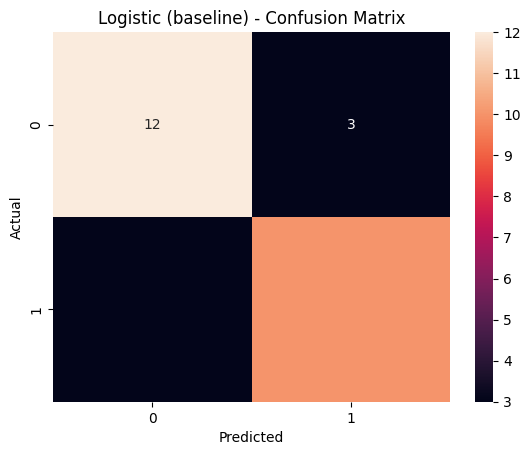

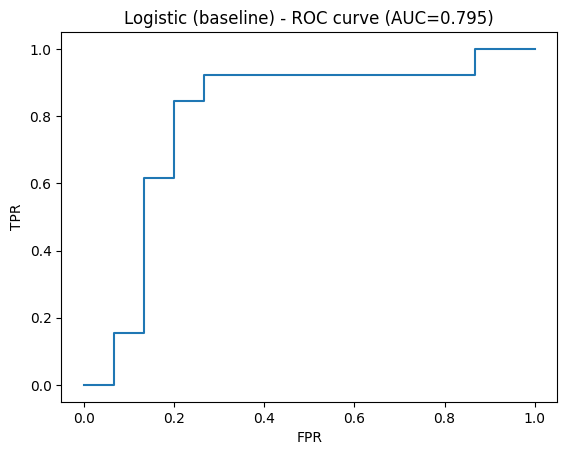

In [183]:
#Fit baseline candidates and evaluate on validation set
print('Fitting Logistic Regression baseline...')
pipe_lr.fit(X_train, y_train)
evaluate_model(pipe_lr, X_val, y_val, 'Logistic (baseline)')

Fitting Random Forest baseline...

RandomForest (baseline) accuracy: 0.6429
              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67        15
         1.0       0.62      0.62      0.62        13

    accuracy                           0.64        28
   macro avg       0.64      0.64      0.64        28
weighted avg       0.64      0.64      0.64        28



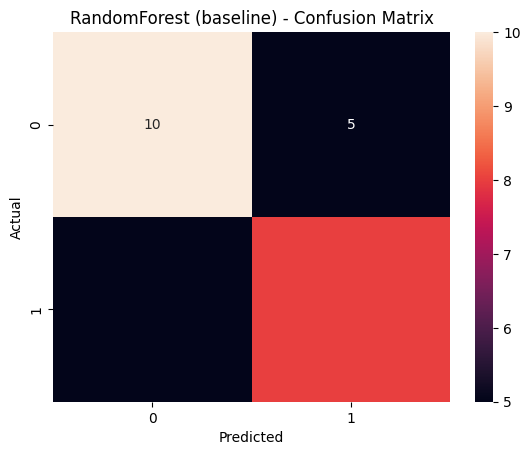

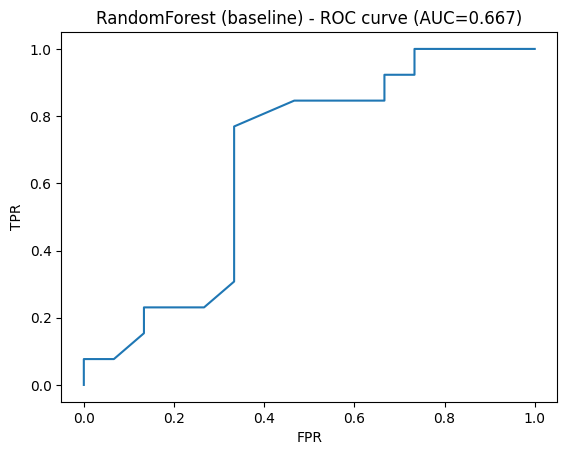

In [184]:
print('Fitting Random Forest baseline...')
pipe_rf.fit(X_train, y_train)
evaluate_model(pipe_rf, X_val, y_val, 'RandomForest (baseline)')

### 7. Hyperparameter Tuning (Grid Search)
- We'll tune PCA components + logistic C for LR and typical RF params for RandomForest

In [198]:
#Define search space of hyperparameters
search_space_lr = [{
               'clf': [LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)],
               'clf__C': np.logspace(-4, 2, 7),
               'pca__n_components':np.linspace(30,37,3).astype(int)
                }]

In [186]:
search_space_rf = [{
    'clf': [RandomForestClassifier(random_state=RANDOM_STATE)],
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [None, 5, 10],
    'clf__max_features': ['sqrt', 'log2']
    }]

In [199]:
# GridSearch for Logistic Regression pipeline
gs_lr = GridSearchCV(pipe_lr, search_space_lr, cv=5)
print('\nRunning GridSearch for LogisticRegression (this may take a while)')
gs_lr.fit(X_train, y_train)
print('Best LR params:', gs_lr.best_params_)


Running GridSearch for LogisticRegression (this may take a while)
Best LR params: {'clf': LogisticRegression(max_iter=2000, random_state=42), 'clf__C': 10.0, 'pca__n_components': 37}


In [195]:
# GridSearch for RandomForest pipeline
gs_rf = GridSearchCV(pipe_rf, search_space_rf, cv=5)
print('\nRunning GridSearch for RandomForest (this may also take a while)')
gs_rf.fit(X_train, y_train)
print('Best RF params:', gs_rf.best_params_)


Running GridSearch for RandomForest (this may also take a while)
Best RF params: {'clf': RandomForestClassifier(random_state=42), 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__n_estimators': 50}


### 10. Model Validation & Selection

In [200]:
best_lr = gs_lr.best_estimator_
best_rf = gs_rf.best_estimator_


Evaluating best Logistic Regression on validation set:

Best Logistic accuracy: 0.7500
              precision    recall  f1-score   support

         0.0       0.79      0.73      0.76        15
         1.0       0.71      0.77      0.74        13

    accuracy                           0.75        28
   macro avg       0.75      0.75      0.75        28
weighted avg       0.75      0.75      0.75        28



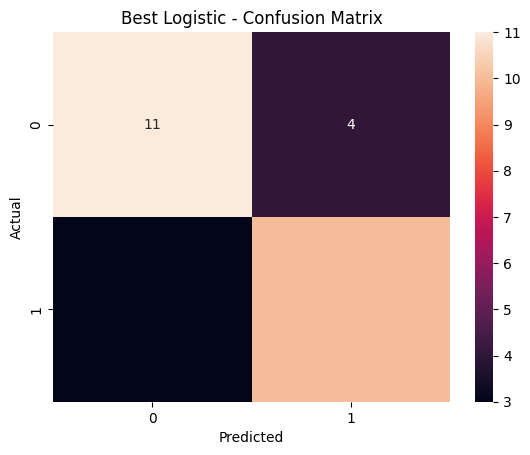

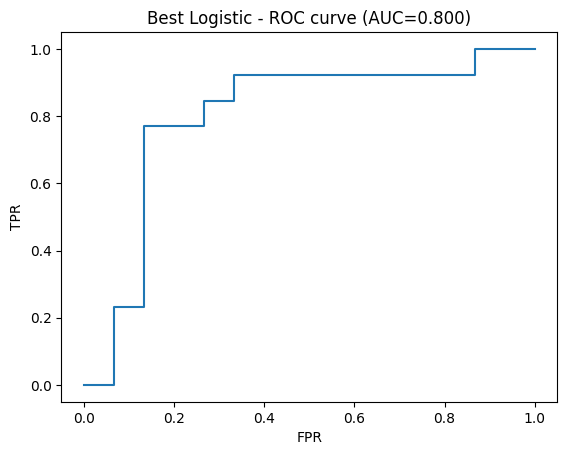

In [201]:
print('\nEvaluating best Logistic Regression on validation set:')
evaluate_model(best_lr, X_val, y_val, 'Best Logistic')


Evaluating best Random Forest on validation set:

Best RandomForest accuracy: 0.6429
              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67        15
         1.0       0.62      0.62      0.62        13

    accuracy                           0.64        28
   macro avg       0.64      0.64      0.64        28
weighted avg       0.64      0.64      0.64        28



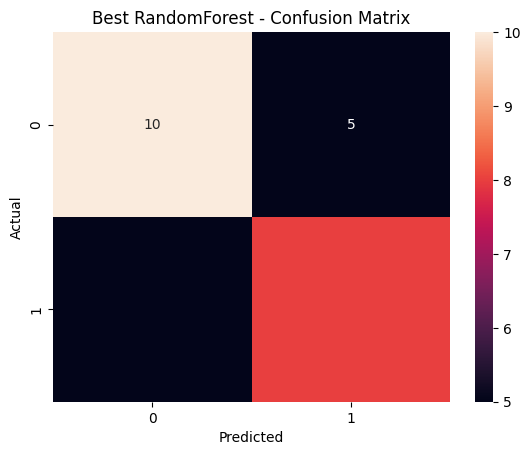

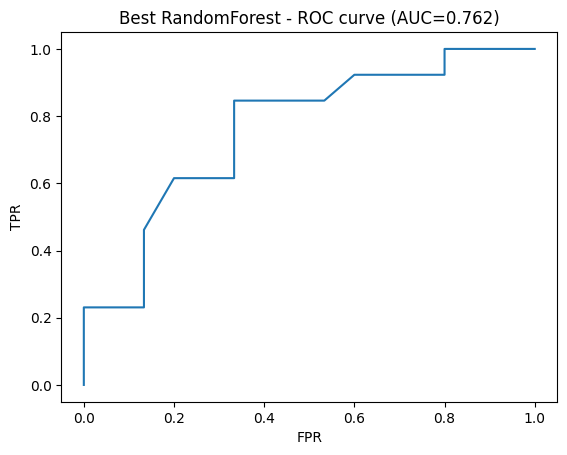

In [202]:
print('\nEvaluating best Random Forest on validation set:')
evaluate_model(best_rf, X_val, y_val, 'Best RandomForest')

In [204]:
# Choose final model based on validation F1 score (or another metric of interest)
f1_lr = f1_score(y_val, best_lr.predict(X_val), zero_division=0)
f1_rf = f1_score(y_val, best_rf.predict(X_val), zero_division=0)
print(f"\nValidation F1 - LR: {f1_lr:.4f}, RF: {f1_rf:.4f}")
final_model = best_rf if f1_rf >= f1_lr else best_lr
print('Selected final model:', final_model.named_steps['clf'])


Validation F1 - LR: 0.7407, RF: 0.6154
Selected final model: LogisticRegression(C=10.0, max_iter=2000, random_state=42)


### 11. Final Training & Test Evaluation


Final Model (Test set) accuracy: 0.5862
              precision    recall  f1-score   support

         0.0       0.60      0.75      0.67        16
         1.0       0.56      0.38      0.45        13

    accuracy                           0.59        29
   macro avg       0.58      0.57      0.56        29
weighted avg       0.58      0.59      0.57        29



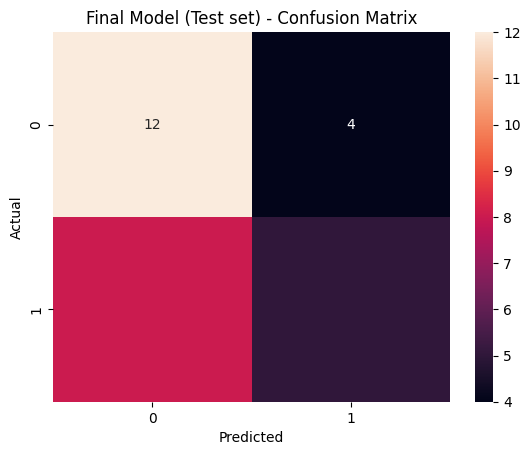

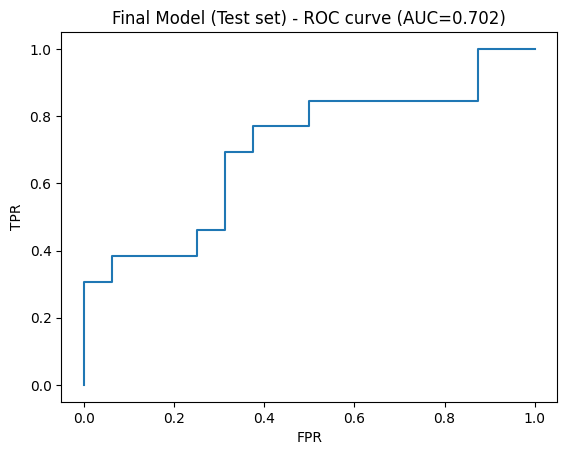

In [205]:
# Retrain the selected final model on the combined train+val data, then evaluate on the untouched test set
final_model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
evaluate_model(final_model, X_test, y_test, 'Final Model (Test set)')

In [206]:
#Save the final pipeline and metadata (for reproducibility)
out_file = 'final_ml_pipeline.joblib'
joblib.dump({'model': final_model, 'numeric_features': num_cols, 'categorical_features': cat_cols}, out_file)
print('Saved final pipeline and metadata to', out_file)

Saved final pipeline and metadata to final_ml_pipeline.joblib


In [210]:
#13. Example: load the pipeline and predict on a new sample
loaded = joblib.load(out_file)
loaded_model = loaded['model']
example = X_test.iloc[[0]] # single-row DataFrame
print('Example true label:', y_test.iloc[0])
print('Example model prediction:', loaded_model.predict(example))

Example true label: 0.0
Example model prediction: [0.]
